## Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
import matplotlib.pyplot as plt  # because Figures >> Text
import numpy as np  # ...of course we need numpy
import palettable as pt  # nicer color pallettes
import pickle  # output export/import

In [2]:
cmap = pt.scientific.sequential.Tokyo_4_r.get_mpl_colormap()

#### Figure 1

What:
Changes in computation times.

Varying parameters:
- $t_{max} = 1eX, X\in\{2,3,4,5,6,7^?\}$
- $N_{agents} = 1eX, X\in\{1,2,3,4,5\}$

Bonus points:
- plot expected number of events $N_{events} \approx (r+h)\cdot N_{nodes}\cdot t_{max}$ for comparison
    - deviations would be due to non-event-related stuffs, e.g. sampling (which will take a toll at some $N_{nodes}$)


In [3]:
# give to-be-analysed data
## I know this is rudimental, but hey, it works for me, for now.

data_dir = "../tests/data/2024-02--Run1/"

# 0.) 2D plot data
n_log = np.arange(1, 4.5, 0.5)  # Leave out n_log=1 (== N=10), because runtime dominated by initialisation
t_log = np.arange(1, 5, 1)
n_arr = [int(10**N) for N in n_log]
t_arr = [int(10**t) for t in t_log]

res_NT = []
res_T = []
res_N = []
for N in n_arr:
    for t in t_arr:
        filename = "out--N_nodes-" + str(N) + "--t_max-" + str(t) + ".pkl"
        res_NT.append(filename)
        if N == 100:
            res_T.append(filename)
        if t == 10000:
            res_N.append(filename)

# 1.) t_max, t_exec (N=100)
for t in [int(10**t) for t in [5, 5.5, 6]]:
    res_T.append("out--t_max-" + str(t) + ".pkl")

# 2.) N_nodes, t_exec (t_max = 10000)
for N in [int(10**N) for N in [4.5]]:
    res_N.append("out--N_nodes-" + str(N) + ".pkl")

In [4]:
# Import pickle data from paramter scan runs:

# Extract 't_exec' for {N_nodes, t_max} adaptions for 3d plot
exec_times_NT = []
exec_times_T = []
exec_times_N = []

for file in res_NT:
    with open(data_dir + file, "rb") as export:
        output = pickle.load(export)
        exec_times_NT.append(output["t_exec"])
exec_times_NT= np.array(exec_times_NT).reshape(len(t_log), len(n_log))

for file in res_T:
    with open(data_dir + file, "rb") as export:
        output = pickle.load(export)
        exec_times_T.append(output["t_exec"])

for file in res_N:
    with open(data_dir + file, "rb") as export:
        output = pickle.load(export)
        exec_times_N.append(output["t_exec"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


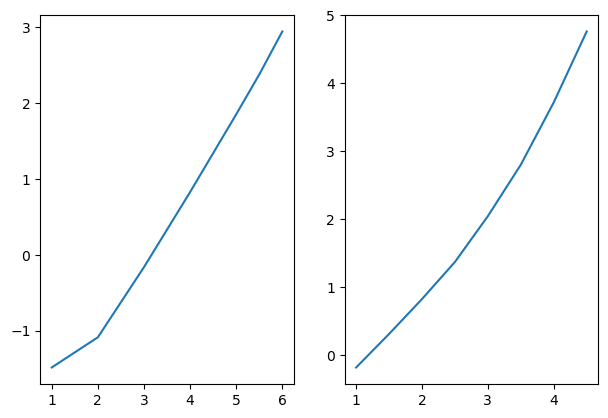

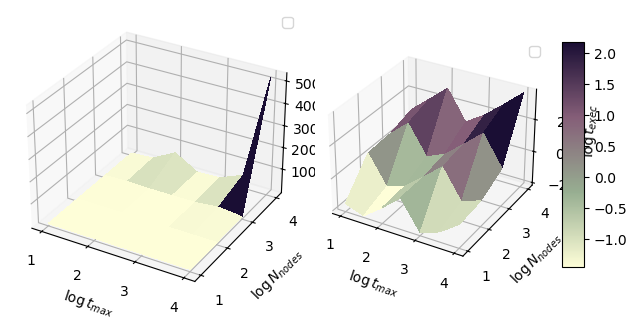

In [5]:
# Plot t_exec data
fig1 = plt.figure(figsize=plt.figaspect(2/3))
fig1.tight_layout()

# t_max, t_exec plot (N=100)
x_T = [1, 2, 3, 4, 5, 5.5, 6]
y_T = np.log10(exec_times_T)

ax1_1 = fig1.add_subplot(1,2,1)
ax1_1.plot(x_T, y_T)

# N_node, t_exec plot (t_max = 10000)
x_N = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
y_N = np.log10(exec_times_N)

ax1_2 = fig1.add_subplot(1,2,2)
ax1_2.plot(x_N, y_N)

# N_node, t_max, t_exec 3D surface plot
x_NT = n_log
y_NT = t_log
x_NT, y_NT = np.meshgrid(x_NT, y_NT)
z_NT = exec_times_NT
z_NT_2 = exec_times_NT

fig2 = plt.figure()
fig2.tight_layout()

ax2_1 = fig2.add_subplot(1,2,1, projection="3d")
surf = ax2_1.plot_surface(x_NT, y_NT, z_NT, cmap=cmap, linewidth=0, antialiased=False)

ax2_1.legend()
#ax2_1.view_init(elev=20., azim=-30, roll=0)    # Customize viewing angle
ax2_1.set_xlabel("$\log t_{max}$")
ax2_1.set_ylabel("$\log N_{nodes}$")
ax2_1.set_zlabel("$t_{exec}$")

ax2_2 = fig2.add_subplot(1,2,2, projection="3d")
surf = ax2_2.plot_surface(x_NT, y_NT, np.log10(z_NT), cmap=cmap, linewidth=0, antialiased=False)
ax2_2.legend()
#ax2_2.view_init(elev=20., azim=-30, roll=0)    # Customize viewing angle
ax2_2.set_xlabel("$\log t_{max}$")
ax2_2.set_ylabel("$\log N_{nodes}$")
ax2_2.set_zlabel("$\log t_{exec}$")



fig2.colorbar(surf, shrink=0.5, aspect=10)

fig2.tight_layout()
plt.show()


## Figure 2

Distance (KLD, lin., quad.), given
1. $(r,h)\in\{ (1,1),(5,5),(0.1,5),(5,0.1)\}$
2. $N_{nodes}\in 1e(1,1.5,2,2.5,3,3.5,4)$

In [6]:
# give to-be-analysed data
## I know this is rudimental, but hey, it works for me, for now.

data_dir = "../tests/data/2024-02--Run1/"

# 1.) (r,h) data
rates = [(1,1),(5,5),(0.1,5),(5,0.1)]
N_log = np.arange(1, 4.5, 0.5)
N_arr = [int(10**N) for N in N_log]

res_rates = []
for N in n_arr:
    for i in rates:
        if i[0] == 1 and i[1] == 1:
            filename = "out--N_nodes-" + str(N) + "--t_max-10000.pkl"
        else:
            filename = "out--N_nodes-" + str(N) + "--r-" + str(i[0]) + "--h-" + str(i[1]) + ".pkl"
        res_rates.append(filename)


In [23]:
res_rates = np.array(res_rates).reshape(7, 4)
print(res_rates[:,0])

['out--N_nodes-10--t_max-10000.pkl' 'out--N_nodes-31--t_max-10000.pkl'
 'out--N_nodes-100--t_max-10000.pkl' 'out--N_nodes-316--t_max-10000.pkl'
 'out--N_nodes-1000--t_max-10000.pkl' 'out--N_nodes-3162--t_max-10000.pkl'
 'out--N_nodes-10000--t_max-10000.pkl']


In [25]:
# Import pickle data from paramter scan runs:

# Extract 't_exec' for {N_nodes, t_max} adaptions for 3d plot
kld_N = []
lin_N = []
quad_N = []

for file in res_rates[:,0]:
    with open(data_dir + file, "rb") as export:
        output = pickle.load(export)
        kld_N.append(
            np.array(output["kl_divs"])[:,1,:]
        )
        lin_N.append(
            np.array(output["p_distances"])[:,0,1,:]
        )
        quad_N.append(
            np.array(output["p_distances"])[:,1,1,:]
        )


In [26]:
N = [10, 31, 100, 316, 1000, 3162, 10000]:
for kld_i in kld_N:
    
for k in range(i):
    kld = kld_N[i]
    plt.plot(250*np.arange(0,kld_N.shape[0]), kld_N[:,k])

AttributeError: 'list' object has no attribute 'shape'